In [1]:
!pip install kagglehub==0.3.3
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [19]:
import sys
sys.path.append('/home/scxie/.local/lib/python3.11/site-packages')

import kagglehub
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
import logging

# Suppress cuDNN plugin registration warnings

In [20]:
# Download latest version of kaggle dataset
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

In [21]:
# Get image paths and create lists to populate later
class_path = path + '/images' + '/images'
classes = os.listdir(class_path)
image_paths = []
labels = [] # Trash category associated with each image
d_r = [] # default (studio/standard) vs real world img


In [22]:
# Access image folders and populate lists with needed data
'''Arthur's shit
for i, label in enumerate(classes):
    class_dir = os.path.join(class_path, label)
    for subfolder in ['default', 'real_world']:
        subfolder_dir = os.path.join(class_dir, subfolder)
        image_names = os.listdir(subfolder_dir)
        
        for j in range(0, len(image_names), int(len(image_names)/3)): # TODO: change step on turn-in
          image_name = image_names[j]
          d_r.append(subfolder)
          image_paths.append(os.path.join(subfolder_dir, image_name)) 
          labels.append(label)
'''

"Arthur's shit\nfor i, label in enumerate(classes):\n    class_dir = os.path.join(class_path, label)\n    for subfolder in ['default', 'real_world']:\n        subfolder_dir = os.path.join(class_dir, subfolder)\n        image_names = os.listdir(subfolder_dir)\n        \n        for j in range(0, len(image_names), int(len(image_names)/3)): # TODO: change step on turn-in\n          image_name = image_names[j]\n          d_r.append(subfolder)\n          image_paths.append(os.path.join(subfolder_dir, image_name)) \n          labels.append(label)\n"

In [23]:
# Access image folders and populate lists with needed data
# Serena's shit
for i, label in enumerate(classes):
    class_dir = os.path.join(class_path, label)
    for subfolder in ['default', 'real_world']:
        subfolder_dir = os.path.join(class_dir, subfolder)
        image_names = os.listdir(subfolder_dir)
        
        for image_name in image_names:
            d_r.append(subfolder)
            image_paths.append(os.path.join(subfolder_dir, image_name))
            labels.append(label)

In [24]:
# Load all data into df
columnDict = {'image_path': image_paths, 'label': labels, 'default_vs_real_world': d_r}
df = pd.DataFrame(columnDict)
df.shape

(15000, 3)

## Clean Data

In [25]:
clean_df = df.copy()
clean_df.label.unique()
cat_dic = {
    'landfill' : ['clothing', 'disposable_plastic_cutlery', 'plastic_shopping_bags', 'plastic_trash_bags',\
                  'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'paper_cups', 'plastic_straws', 'plastic_cup_lids'],
    'recyclable' : ['aerosol_cans','aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'glass_beverage_bottles',\
                    'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'plastic_detergent_bottles',\
                    'plastic_food_containers','plastic_soda_bottles', 'plastic_water_bottles', 'steel_food_cans'],
    'compost' : ['coffee_grounds', 'eggshells', 'food_waste', 'tea_bags']
}

# Create a reverse lookup dictionary to map items to categories
item_to_category = {item: category for category, items in cat_dic.items() for item in items}

# Map the labels to respective categories using lookup dictionary
clean_df['category'] = df['label'].map(item_to_category)
clean_df.head()

,image_path,label,default_vs_real_world,category
0,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
1,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
2,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
3,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill
4,/home/scxie/.cache/kagglehub/datasets/alistair...,disposable_plastic_cutlery,default,landfill


In [26]:
def subset(df, num):
    """
    Gets subset of dataframe. USE THIS FOR WORKING LOCALLY ONLY.

    ARGS:
        df: dataframe 
        num(float): decimal representing what amt of original df you wanna use for subset (eg. .5 or .3)
    RETURNS:
        df: smaller df that's shuffled
    """
    return df.sample(frac=num, random_state=42).reset_index(drop=True)
    
# CHANGE frac TO 1 WHEN USING SUPER COMPUTER 
frac = 0.5 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
tiny_df = subset(clean_df, frac)
tiny_df.shape

(7500, 4)

In [27]:
def train_val_test(df):
    """
    Split df into train, val, test. HARDCODED to 60% train, 20% val and 20% test btw
    """
    # Get rid of unnecessary columns HARDCODED
    df = df[['image_path', 'category']]
    # Split into train and temp (40% for validation + test)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
    
    # Split temp into validation and test (10% each)
    val_df, test_df = train_test_split(df, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")
    return train_df, val_df, test_df

train_df, val_df, test_df = train_val_test(tiny_df)
train_df.head()

Train size: 4500, Validation size: 3750, Test size: 3750


,image_path,category
2346,/home/scxie/.cache/kagglehub/datasets/alistair...,compost
68,/home/scxie/.cache/kagglehub/datasets/alistair...,recyclable
5487,/home/scxie/.cache/kagglehub/datasets/alistair...,recyclable
6911,/home/scxie/.cache/kagglehub/datasets/alistair...,recyclable
6642,/home/scxie/.cache/kagglehub/datasets/alistair...,recyclable


In [28]:
def to_tensorflow(df, shuffle=True):
    """
    Convert pandas df to tensorflow dataset.
    ARGS:
        df: pandas df
    RETURNS 
        gen: tensorflow dataset
    """
    preprocess = tf.keras.applications.vgg16.preprocess_input # preprocessing function for CNN 
    target_size=(224,224) # set the size of the images
    color_mode='rgb' # set the type of image
    class_mode= 'categorical' # set the class mode
    batch_size=32  # set the batch size 
    gen=ImageDataGenerator(preprocessing_function=preprocess).flow_from_dataframe(df, 
          x_col='image_path',
          y_col='category', target_size=target_size, color_mode=color_mode,
          class_mode=class_mode, batch_size=batch_size, shuffle=shuffle)
    return gen
pandas_dfs = [train_df, val_df]
train_batches, val_batches = [to_tensorflow(df) for df in pandas_dfs]
test_batches = to_tensorflow(test_df, shuffle=False) # don't shuffle test batch

Found 4500 validated image filenames belonging to 3 classes.
Found 3750 validated image filenames belonging to 3 classes.
Found 3750 validated image filenames belonging to 3 classes.


## Train and Validation

In [29]:
# generate batch of images and labels from training set
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

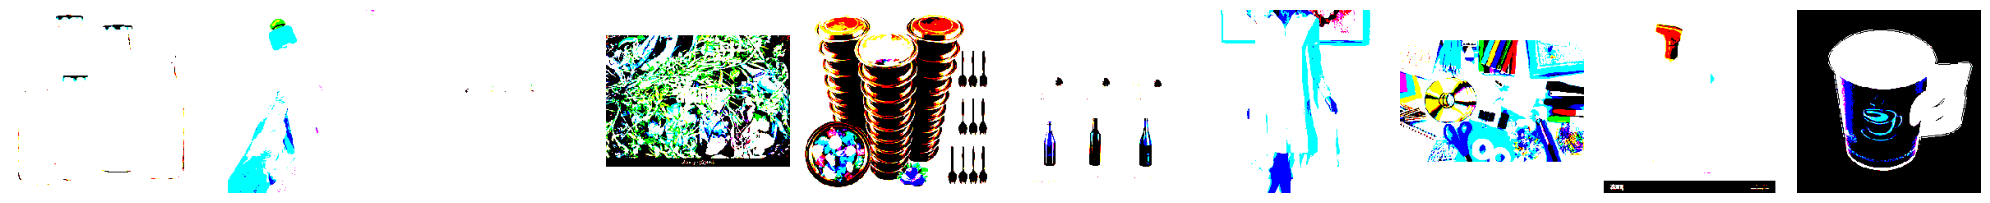

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs) # images look fucky because of the preprocessing function 
print(labels) # one hot encoding of categories

In [31]:
# Build CNN
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=3, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                

In [33]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=val_batches,
    validation_steps=len(val_batches),
    epochs=20,
    verbose=2,
    workers=-1,
    use_multiprocessing=True,
)

Epoch 1/20
141/141 - 263s - loss: 30.1557 - accuracy: 0.5036 - val_loss: 0.9505 - val_accuracy: 0.5477 - 263s/epoch - 2s/step
Epoch 2/20
141/141 - 274s - loss: 0.9321 - accuracy: 0.5549 - val_loss: 0.8510 - val_accuracy: 0.6040 - 274s/epoch - 2s/step
Epoch 3/20
141/141 - 261s - loss: 0.8075 - accuracy: 0.6331 - val_loss: 0.6058 - val_accuracy: 0.7296 - 261s/epoch - 2s/step
Epoch 4/20
141/141 - 240s - loss: 0.5983 - accuracy: 0.7367 - val_loss: 0.3920 - val_accuracy: 0.8475 - 240s/epoch - 2s/step
Epoch 5/20
141/141 - 269s - loss: 0.3979 - accuracy: 0.8340 - val_loss: 0.2592 - val_accuracy: 0.8901 - 269s/epoch - 2s/step
Epoch 6/20
141/141 - 274s - loss: 0.2471 - accuracy: 0.8960 - val_loss: 0.1476 - val_accuracy: 0.9592 - 274s/epoch - 2s/step
Epoch 7/20
141/141 - 273s - loss: 0.1732 - accuracy: 0.9396 - val_loss: 0.1161 - val_accuracy: 0.9637 - 273s/epoch - 2s/step
Epoch 8/20
141/141 - 269s - loss: 0.1531 - accuracy: 0.9542 - val_loss: 0.1580 - val_accuracy: 0.9579 - 269s/epoch - 2s/step

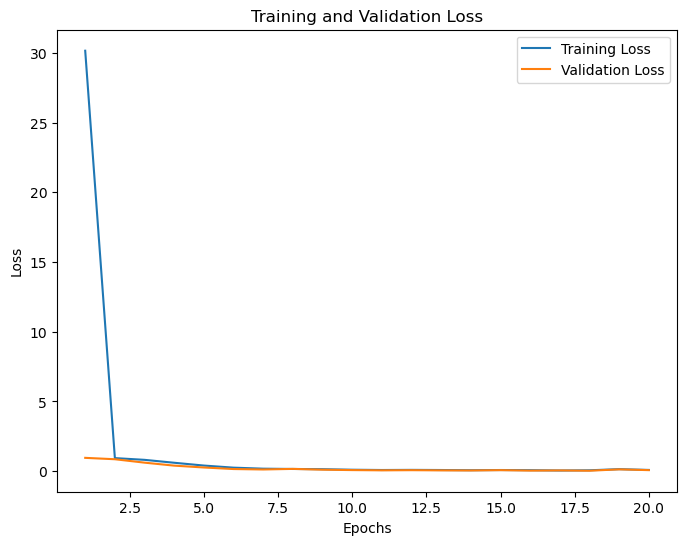

In [36]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

# Adding labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

## Predict on Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

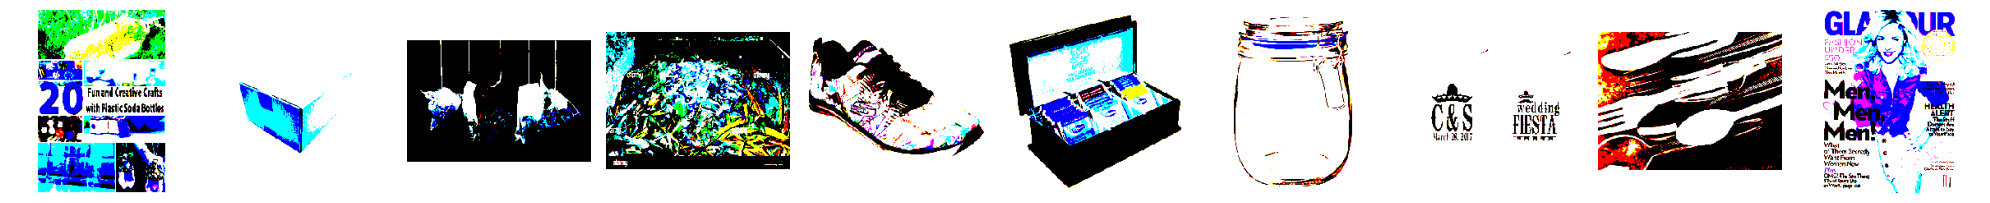

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [37]:
# Take a look at the test images
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [38]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [39]:
# Show predictions rounded
np.round(predictions) 

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [40]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [41]:
# True y
# test_batches.classes

In [42]:
# CODE COPIED FROM SCI-KIT LEARN
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
test_batches.class_indices

{'compost': 0, 'landfill': 1, 'recyclable': 2}

Confusion matrix, without normalization
[[ 275   94  120]
 [  48  834  373]
 [  70  376 1560]]


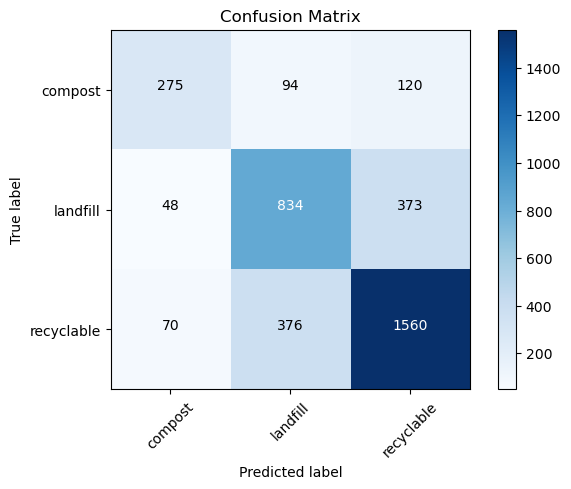

In [44]:
cm_plot_labels = ['compost','landfill', 'recyclable']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [46]:
# Assuming test_batches is a generator like ImageDataGenerator for your test data
loss, accuracy = model.evaluate(test_batches, verbose=1)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

118/118 [==============================] - 60s 508ms/step - loss: 3.0177 - accuracy: 0.7117
Test Loss: 3.0177485942840576
Test Accuracy: 71.17%


In [47]:
history